# Monte Carlo Control with exploration starts

In [1]:
from blackjack import BlackJack
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 180)

In [2]:
game = BlackJack()
epochs = 1_000_000
alpha = .1

actions = ["hit", "stand", "double"]

# intialize Q(s,a) = 0, pi(s) = random a, N(s) = 0
Q = {state : {a : 0 for a in actions} for state in game.states} # Q values
pi = {state : random.choice(actions) for state in game.states} # policy
N = {state : 0 for state in game.states} # number of times states are visited
rewards = [0] * epochs

for i in range(epochs):
    
    if i % (epochs / 10) == 0:
        print(i)
    
    #game.start() # sample all states with probabilities proportional to the frequency of their occurence in a simulated game
    game.start_from_state(random.choice(game.states)) # sample all states uniformly
    
    first = True
    
    visited_states = []
    performed_actions = []
    
    while game.player_hand_sum < 21: # while the player hasn't busted
        
        state = game.get_current_state()
        
        action = pi[state] # greedy policy
        
        # if the state is first in the trajectory, the action is random
        # that facilitates exploration starts
        if first:
            action = random.choice(actions)
            first = False
        
        visited_states.append(state)
        performed_actions.append(action)
        
        if action == "hit":
            game.hit()
        elif action == "stand":
            game.stand() # if we stand, the round ends
            break
        else:
            game.double() # if we double, the round ends because double = hit -> stand
            break
    
    # store reward
    reward = game.get_reward()
    rewards[i] = reward
    
    # update Q
    for s, a in zip(visited_states, performed_actions):
        
        N[s] += 1 # count occurences of states
        
        # update the Q-value
        Q[s][a] += (reward - Q[s][a]) / N[s] # Q-value = mean of all returns 
        #Q[s][a] += alpha * (reward - Q[s][a]) # incremental update; recently observed returns are more valuable
        
    # update the policy
    for s in visited_states:
        
        pi[s] = max(Q[s], key = Q[s].get)
    

Object created
0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [3]:
game.test_policy(pi, 1_000_000)

Winrate: 0.42635802033387815
Drawrate: 0.08369488684596825
Loserate: 0.4899470928201536
Ws: 471106; Ls: 541369; Draws: 92479
Profit: -68905
Wins after doubling: 17099; Losses after doubling: 16327


Below this are some plotting attempts

In [17]:
sums = [a for (a,_,_) in pi]
ace = [b for (_,b,_) in pi]
card = [c for (_,_,c) in pi]

df = pd.DataFrame({"sum" : sums, "ace" : ace, "card" : card, 
                   "action" : pi.values(), "n" : N.values()})

In [18]:
with_ace = df[df["ace"] == True][["sum", "card", "action"]]
no_ace = df[df["ace"] == False][["sum", "card", "action"]]

with_ace['action'] = with_ace['action'].map({"hit" : "red", "stand" : "blue", "double" : "green"})
no_ace['action'] = no_ace['action'].map({"hit" : "red", "stand" : "blue", "double" : "green"})

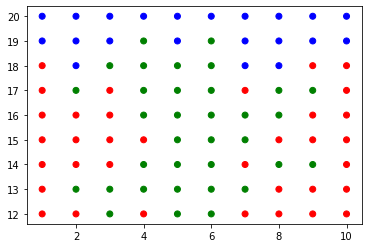

In [19]:
plt.scatter(with_ace["card"], with_ace["sum"], c = with_ace["action"])
plt.show()

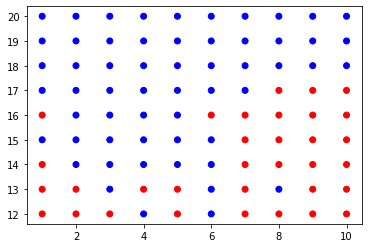

In [20]:
plt.scatter(no_ace["card"], no_ace["sum"], c = no_ace["action"])
plt.show()